In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


import configparser
config = configparser.ConfigParser()
config.read_file(open('config/config-tjander.ini'))

client_attributes_file_path = config['data-files']['clients_attributes']
active_promos_file_path = config['data-files']['active_promos']
executed_promos_file_path = config['data-files']['executed_promos']
sales_file_path = config['data-files']['sales']


In [2]:
for root, dirs, files in os.walk("."):
    for filename in files:
        print(filename)

.editorconfig
azure-vlad.ipynb
local-tj-bayes-oversampling.ipynb
local-tj-bayes-undersampling.ipynb
local-vlad-bayes-2.ipynb
local-vlad-bayes-noduplicados.ipynb
modelo bayes Tj Azure.ipynb
modelo bayes Tj-Copy1.ipynb
modelo bayes Tj.ipynb
prediction.csv
README.md
reto-notebook.ipynb
reto.py
COMMIT_EDITMSG
config
description
FETCH_HEAD
HEAD
index
ORIG_HEAD
packed-refs
applypatch-msg.sample
commit-msg.sample
fsmonitor-watchman.sample
post-update.sample
pre-applypatch.sample
pre-commit.sample
pre-merge-commit.sample
pre-push.sample
pre-rebase.sample
pre-receive.sample
prepare-commit-msg.sample
update.sample
exclude
HEAD
stash
main
HEAD
main
f36689ce57e27911c21a7ae2f51c5c09ded80c
53c9aed43511b6c1e3757b29724d65d968e04d
91c58590207275522fbb794484e40d50801f96
d4df7456410dac07651d5353a64c49eb379af2
efb340b13b476568f6db9b4fd6ab89e12733da
05634a659c2dcacb0661012a01b195e7999d02
d6483cbfa25f9ebd6a6ac28075d87fe58dfe53
130bb2688af0fcc05eeec7543455fee01fef3b
694f9af97150bd309cce259d60282ad7c6158d
ed5

In [3]:
sales = pd.read_csv(sales_file_path, encoding='latin-1')
# sales[sales['Dcto'] < 0]
sales

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0
3,1,2018,7,1,2.0,37,34.0,1944.01,0.01,0.0
4,1,2018,8,2,1.0,2,16.0,16250.18,0.06,0.0
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,2019,8,1,2.0,44,32.0,3777.28,0.01,0.0
1894248,15069,2019,3,1,2.0,44,32.0,6295.46,0.02,0.0
1894249,15069,2019,4,1,2.0,44,32.0,6295.46,0.02,0.0
1894250,15069,2019,4,2,1.0,2,6.0,15741.56,0.08,0.0


In [4]:
# 0	297601	8410	29	9
# sales[(sales['Cliente'] == 8410) & (sales['Marca'] == 29) & (sales['Cupo'] == 9)]
x = sales[(sales['Cliente'] == 8410) & (sales['Marca'] == 29) & (sales['Cupo'] == 9)]
x['Cliente']

853830    8410
Name: Cliente, dtype: int64

In [5]:
executed_promos = pd.read_csv(executed_promos_file_path, encoding='latin-1')
sanitized_executed_promos = executed_promos.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
sanitized_executed_promos

,CodigoDC,Cliente,Marca,Cupo
0,297601,8410,29,9
1,297601,9337,29,9
2,309843,7404,40,16
3,309874,4017,40,16
4,309910,6316,40,16
...,...,...,...,...
27763,646815,2144,29,9
27764,646976,28,29,9
27765,647188,10023,29,9
27766,648099,10193,29,9


In [6]:
active_promos = pd.read_csv(active_promos_file_path, encoding='latin-1')
active_promos

,CodigoDC,Marca,Cupo,Fecha_Desde,Fecha_Hasta,Cliente
0,297601,29,9,2018-08-06,2018-08-30,3213
1,297601,29,9,2018-08-06,2018-08-30,3795
2,297601,29,9,2018-08-06,2018-08-30,11816
3,298856,40,16,2018-08-12,2018-08-19,8444
4,309916,40,16,2018-08-12,2018-08-19,8488
...,...,...,...,...,...,...
422432,688354,40,16,2019-09-25,2019-09-26,14435
422433,688355,29,9,2019-09-25,2019-09-26,320
422434,688355,29,9,2019-09-25,2019-09-26,3117
422435,688355,29,9,2019-09-25,2019-09-26,3503


In [7]:
clients_attributes = pd.read_csv(client_attributes_file_path, encoding='latin-1')
clients_attributes

,Cliente,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,1,2009-03-03,4,21,12,1,1,1
1,9,2009-03-03,4,21,9,2,3,1
2,15,2009-03-03,4,21,9,2,3,0
3,37,2009-03-03,4,21,16,2,3,1
4,43,2009-03-03,4,21,9,2,3,0
...,...,...,...,...,...,...,...,...
15064,15040,2019-03-07,1,16,9,2,1,0
15065,15043,2019-03-07,1,20,15,2,2,1
15066,15052,2019-03-09,3,7,10,2,2,0
15067,15065,2019-03-16,4,21,9,2,2,0


In [8]:
sales_exec_promos = sales.merge(sanitized_executed_promos, how = 'left', on = ['Cliente', 'Marca', 'Cupo'])
sales_exec_promos.loc[sales_exec_promos['CodigoDC'].isnull() == False, 'ES_PROMO'] = 'SI'
sales_exec_promos.loc[sales_exec_promos['CodigoDC'].isnull() == True, 'ES_PROMO'] = 'NO'

sales_exec_promos


,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,CodigoDC,ES_PROMO
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0,NaN,NO
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0,NaN,NO
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0,NaN,NO
3,1,2018,7,1,2.0,37,34.0,1944.01,0.01,0.0,NaN,NO
4,1,2018,8,2,1.0,2,16.0,16250.18,0.06,0.0,NaN,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
1894247,15068,2019,8,1,2.0,44,32.0,3777.28,0.01,0.0,NaN,NO
1894248,15069,2019,3,1,2.0,44,32.0,6295.46,0.02,0.0,NaN,NO
1894249,15069,2019,4,1,2.0,44,32.0,6295.46,0.02,0.0,NaN,NO
1894250,15069,2019,4,2,1.0,2,6.0,15741.56,0.08,0.0,NaN,NO


In [9]:
df = sales_exec_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
df.columns.tolist()

['Cliente',
 'Año',
 'Mes',
 'ClaseEnvase',
 'SegmentoPrecio',
 'Marca',
 'Cupo',
 'Nr',
 'Hl',
 'Dcto',
 'CodigoDC',
 'ES_PROMO',
 'FechaAltaCliente',
 'Region',
 'Gerencia',
 'SubCanal',
 'TipoPoblacion',
 'Estrato',
 'EF']

In [10]:
df=df[['Cliente','Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF','ES_PROMO']]
df

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,1,44,10.0,4,21,12,1,1,1,NO
1,1,18,16.0,4,21,12,1,1,1,NO
2,1,2,6.0,4,21,12,1,1,1,NO
3,1,37,34.0,4,21,12,1,1,1,NO
4,1,2,16.0,4,21,12,1,1,1,NO
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,44,32.0,1,5,9,2,3,1,NO
1894248,15069,44,32.0,4,14,9,2,1,0,NO
1894249,15069,44,32.0,4,14,9,2,1,0,NO
1894250,15069,2,6.0,4,14,9,2,1,0,NO


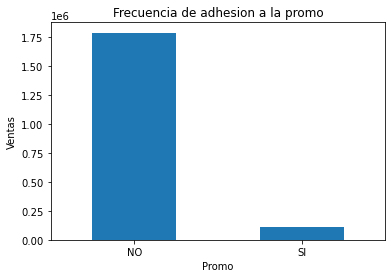

In [11]:
count_class = pd.value_counts(df['ES_PROMO'], sort = True)
count_class.plot(kind= 'bar', rot= 0)
plt.title('Frecuencia de adhesion a la promo')
plt.xlabel('Promo')
plt.ylabel('Ventas')
plt.show()

In [12]:
d = defaultdict(preprocessing.LabelEncoder)

In [13]:
tipos = df.columns.to_series().groupby(df.dtypes).groups

object_list = list(tipos[np.dtype('object')])
object_list

['ES_PROMO']

In [14]:
fit=df.apply(lambda x: d[x.name].fit_transform(x) if x.name in object_list else x)

fit.apply(lambda x: d[x.name].inverse_transform(x) if x.name in object_list else x)

df=df.apply(lambda x: d[x.name].transform(x) if x.name in object_list else x)
df.head()

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,1,44,10.0,4,21,12,1,1,1,0
1,1,18,16.0,4,21,12,1,1,1,0
2,1,2,6.0,4,21,12,1,1,1,0
3,1,37,34.0,4,21,12,1,1,1,0
4,1,2,16.0,4,21,12,1,1,1,0


In [15]:
df.isnull().any()

Cliente          False
Marca            False
Cupo              True
Region           False
Gerencia         False
SubCanal         False
TipoPoblacion    False
Estrato          False
EF               False
ES_PROMO         False
dtype: bool

In [16]:
df['Cupo'].isnull().sum()

5

In [17]:
df = df.fillna({'Cupo': df['Cupo'].mode()[0]})
df

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,1,44,10.0,4,21,12,1,1,1,0
1,1,18,16.0,4,21,12,1,1,1,0
2,1,2,6.0,4,21,12,1,1,1,0
3,1,37,34.0,4,21,12,1,1,1,0
4,1,2,16.0,4,21,12,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,44,32.0,1,5,9,2,3,1,0
1894248,15069,44,32.0,4,14,9,2,1,0,0
1894249,15069,44,32.0,4,14,9,2,1,0,0
1894250,15069,2,6.0,4,14,9,2,1,0,0


In [18]:
class_y= list(d['ES_PROMO'].classes_)
class_y

['NO', 'SI']

In [19]:
d['ES_PROMO'].transform(class_y)

array([0, 1], dtype=int64)

In [20]:
x, y = df.iloc[:, 0:9].values, df.iloc[:, 9].values

x_train, x_test, y_train, y_test =\
    train_test_split(x, y, 
                     test_size=0.3,
                     random_state=0, 
                     stratify=y)

In [22]:
o_sample= RandomOverSampler(0.7)
x_t_os, y_t_os= o_sample.fit_sample(x_train, y_train)

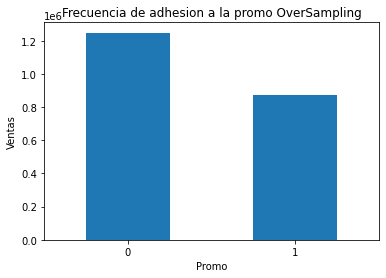

In [23]:
count_class = pd.value_counts(y_t_os, sort = True)
count_class.plot(kind= 'bar', rot= 0)
plt.title('Frecuencia de adhesion a la promo OverSampling')
plt.xlabel('Promo')
plt.ylabel('Ventas')
plt.show()

In [24]:
columnas = list(df.columns)
predictores = list(columnas[0:9])
target = columnas[9]

In [26]:
data_train_xs = pd.DataFrame(x_t_os, columns=predictores)
data_train_y = pd.DataFrame(y_t_os, columns=[target])
data_train = pd.concat([data_train_xs,data_train_y],axis=1)
data_train.head()

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,1884.0,6.0,25.0,1.0,5.0,15.0,2.0,3.0,1.0,0
1,4720.0,44.0,33.0,5.0,11.0,9.0,2.0,1.0,0.0,0
2,7163.0,34.0,7.0,4.0,14.0,16.0,1.0,2.0,1.0,0
3,3244.0,6.0,16.0,3.0,7.0,15.0,2.0,2.0,1.0,0
4,12980.0,40.0,16.0,5.0,19.0,12.0,2.0,2.0,1.0,1


In [27]:
data_test_xs = pd.DataFrame(x_test, columns=predictores)
data_test_y = pd.DataFrame(y_test, columns=[target])
data_test = pd.concat([data_test_xs,data_test_y],axis=1)
data_test.head()

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,4976.0,17.0,23.0,1.0,20.0,15.0,2.0,1.0,1.0,0
1,9769.0,44.0,30.0,4.0,6.0,9.0,2.0,1.0,0.0,0
2,8541.0,2.0,16.0,5.0,19.0,18.0,2.0,1.0,0.0,0
3,6100.0,26.0,16.0,3.0,8.0,15.0,2.0,3.0,1.0,0
4,10042.0,44.0,32.0,1.0,23.0,24.0,2.0,3.0,0.0,0


In [28]:
x_train, y_train = data_train.iloc[:, 0:9].values, data_train.iloc[:, 9].values
x_test, y_test = data_test.iloc[:, 0:9].values, data_test.iloc[:, 9].values

In [29]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_test, y_test)

GaussianNB()

In [30]:
#El score de la data de entrenamiento 
clf.score(x_train, #x de entrenamiento balanceado por oversampling
          y_train) #y de entrenamiento balanceado por oversampling

0.89233133153355

In [31]:
#El score de la data de testeo
clf.score(x_test, #x de testeo 
          y_test) #y de testeo *no se balancea

0.933345768605396

In [32]:
#La probabilidad de pertenecer a la clase
probs_test = clf.predict_proba(x_test)
probs_test

array([[1.00000000e+000, 2.81727791e-043],
       [1.00000000e+000, 2.40374404e-013],
       [1.00000000e+000, 7.90613238e-112],
       ...,
       [1.00000000e+000, 9.47477452e-017],
       [1.00000000e+000, 3.44160227e-112],
       [1.00000000e+000, 2.77854300e-089]])

In [33]:
prob_test = probs_test[:,1]
prob_test_df = pd.DataFrame(prob_test)
# prob_test_df.colums=['No_Promo']
prob_test_df

,0
0,2.817278e-43
1,2.403744e-13
2,7.906132e-112
3,9.583601e-15
4,1.219995e-16
...,...
568271,6.850552e-19
568272,5.845158e-01
568273,9.474775e-17
568274,3.441602e-112


In [34]:
############## ONLY TO SEE THE MATRIX #####################

In [35]:
threshold = 0.5 #punto de corte de 0.5
prob_test_df['Pred'] = np.where(prob_test_df[0]>threshold, 1, 0)
prob_test_df

#La matriz de confusion con la data de testeo
confusion_matrix = pd.crosstab(prob_test_df.Pred, y_test)
confusion_matrix

col_0,0,1
Pred,,
0,503270,5789
1,32089,27128


In [36]:
############################################################

### Predicción en base a Cliente y Promociones Activas

In [37]:
x_test[0]

array([4.976e+03, 1.700e+01, 2.300e+01, 1.000e+00, 2.000e+01, 1.500e+01,
       2.000e+00, 1.000e+00, 1.000e+00])

In [38]:
df

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,ES_PROMO
0,1,44,10.0,4,21,12,1,1,1,0
1,1,18,16.0,4,21,12,1,1,1,0
2,1,2,6.0,4,21,12,1,1,1,0
3,1,37,34.0,4,21,12,1,1,1,0
4,1,2,16.0,4,21,12,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1894247,15068,44,32.0,1,5,9,2,3,1,0
1894248,15069,44,32.0,4,14,9,2,1,0,0
1894249,15069,44,32.0,4,14,9,2,1,0,0
1894250,15069,2,6.0,4,14,9,2,1,0,0


In [39]:
cli_active_promo = active_promos.merge(clients_attributes, how = 'left', on = 'Cliente')
columns = df.columns.tolist()
index_target = columns.index('ES_PROMO')
del columns[index_target]

cli_active_promo = cli_active_promo[columns]
cli_active_promo.head(1)

,Cliente,Marca,Cupo,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,3213,29,9,3,8,15,2,3,1


In [40]:
# tipos = cli_active_promo.columns.to_series().groupby(df.dtypes).groups

# tipos
# object_list = list()
# object_list

# fit=cli_active_promo.apply(lambda x: d[x.name].fit_transform(x) if x.name in object_list else x)

# fit.apply(lambda x: d[x.name].inverse_transform(x) if x.name in object_list else x)

# df=df.apply(lambda x: d[x.name].transform(x) if x.name in object_list else x)
# df.head()

prediction_results = clf.predict_proba(cli_active_promo.values)

prediction_results

prediction_df = pd.DataFrame(prediction_results, columns = ['No_Ejecuto_Promo', 'Ejecuto_Promo'])


In [41]:
prediction_df#[prediction_df[1] > 0.5]
pred_merged_df = pd.concat([active_promos,prediction_df],axis=1)

# resultado_final
pred_no_dupes_df = pred_merged_df.drop_duplicates(subset = ['Cliente', 'Marca', 'Cupo'])
result = pred_no_dupes_df[['Cliente', 'Marca', 'Cupo', 'Ejecuto_Promo']].set_index('Cliente')

In [43]:
import tempfile
output_filename = "{}/{}".format(tempfile.gettempdir(), "bayes_oversample.csv")

print("GUARDANDO EL OUTPUT EN {} ...".format(output_filename))
result
result.to_csv(output_filename)

GUARDANDO EL OUTPUT EN C:\Users\Tjander\AppData\Local\Temp/bayes_oversample.csv ...
